In [1]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size)

from toolkit.constants import (
    folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)
from toolkit.classes import (
    IterationResult,
    Factorizer
)
from toolkit.evaluate import (
    evaluate_algorithms
)

#%matplotlib widget
import tensorly as tl
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from copy import deepcopy

## Evaluate All Algorithms


Testing on random generated tensors:
Dimension of tensor: (10, 10, 10), noise: 0.19581555082088276, F: 2, norm: 268.08794573953327
Multiplicative converged in 0.415 seconds and 306 iterations
Multiplicative Poisson converged in 0.160 seconds and 109 iterations
Geometric step size calculation without rescaling converged in 0.616 seconds and 79 iterations
Geometric step size calculation with normalization converged in 4.543 seconds and 1001 iterations
Geometric step size calculation with max = 1 converged in 2.208 seconds and 462 iterations
Geometric step size calculation with mean = 1 converged in 0.416 seconds and 66 iterations
Dimension of tensor: (20, 20, 5), noise: 0.0548470827955148, F: 4, norm: 145.34721958397813
Multiplicative converged in 0.724 seconds and 1001 iterations
Multiplicative Poisson converged in 1.968 seconds and 1001 iterations
Geometric step size calculation without rescaling converged in 1.576 seconds and 258 iterations
Geometric step size calculation with normal

C:\Users\David\Documents\GitHub\GeometricTensorFactorization\toolkit\evaluate.py:69: RuntimeWarning: invalid value encountered in divide
  im /= im.max()
C:\Users\David\Documents\GitHub\GeometricTensorFactorization\toolkit\evaluate.py:71: RuntimeWarning: invalid value encountered in cast
  return im.astype(np.uint8)


Geometric step size calculation with normalization converged in 1.916 seconds and 308 iterations
Geometric step size calculation with max = 1 converged in 1.604 seconds and 180 iterations
Geometric step size calculation with mean = 1 converged in 1.858 seconds and 188 iterations

Factorizing image coffeewith F = 4
Multiplicative converged in 0.612 seconds and 385 iterations
Multiplicative Poisson converged in 0.624 seconds and 213 iterations
Geometric step size calculation without rescaling converged in 3.299 seconds and 277 iterations
Geometric step size calculation with normalization converged in 0.931 seconds and 138 iterations
Geometric step size calculation with max = 1 converged in 1.086 seconds and 108 iterations
Geometric step size calculation with mean = 1 converged in 0.983 seconds and 94 iterations

Factorizing image astronautwith F = 5
Multiplicative converged in 0.814 seconds and 545 iterations
Multiplicative Poisson converged in 0.444 seconds and 103 iterations
Geometric 

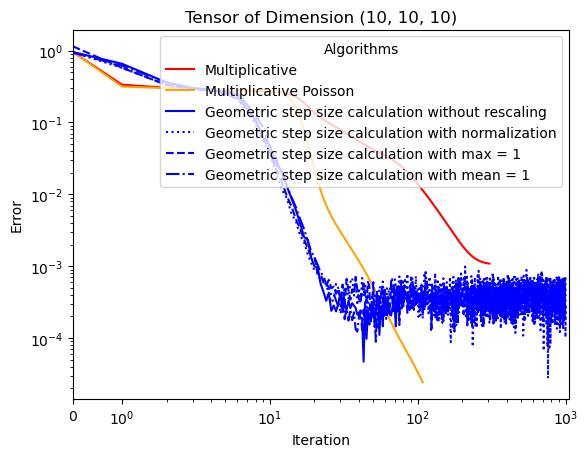

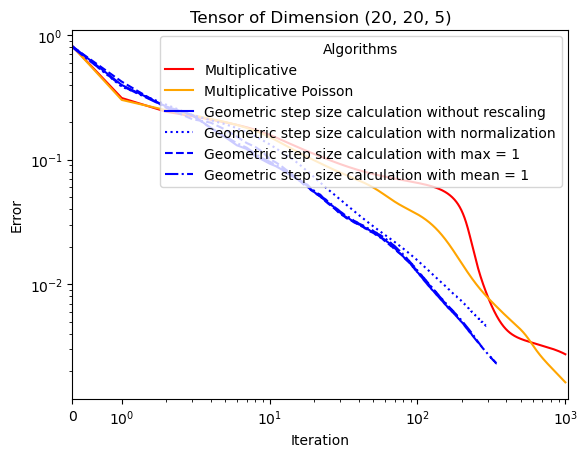

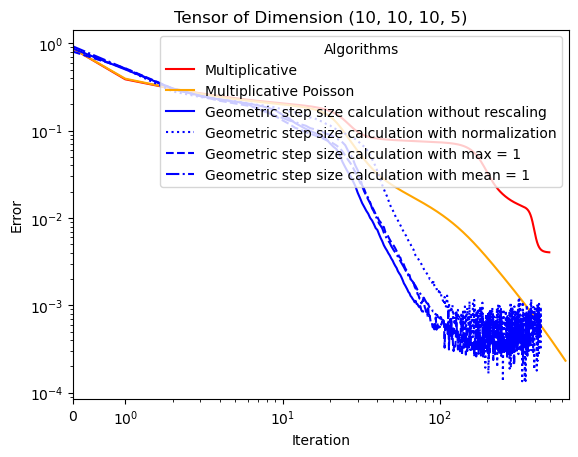

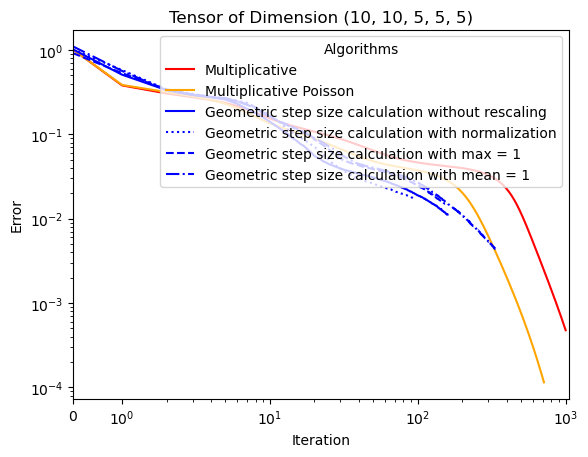

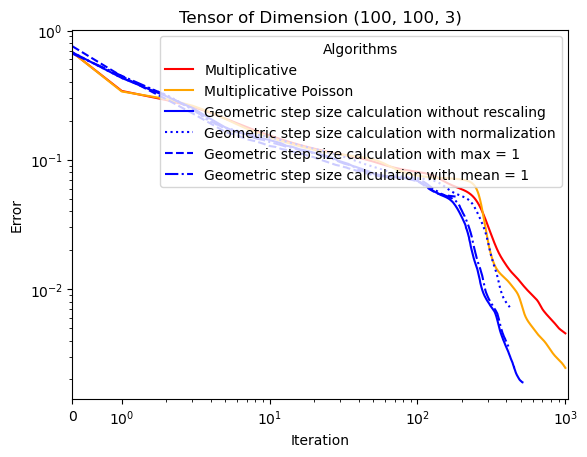

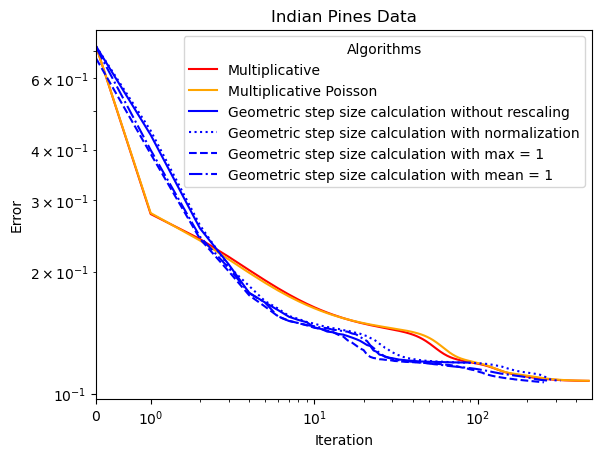

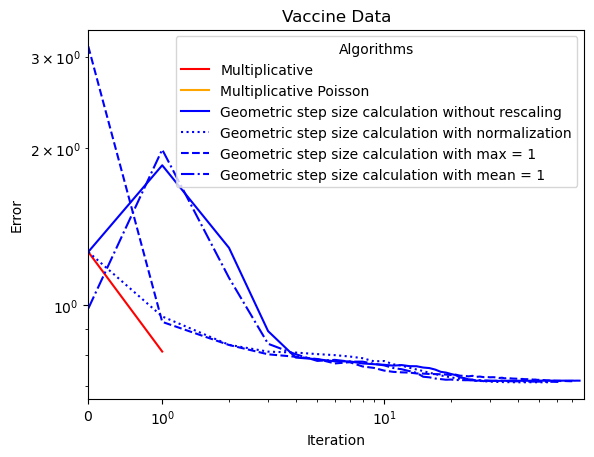

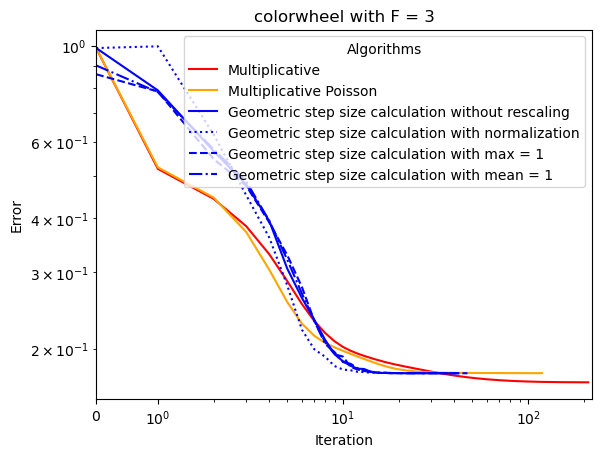

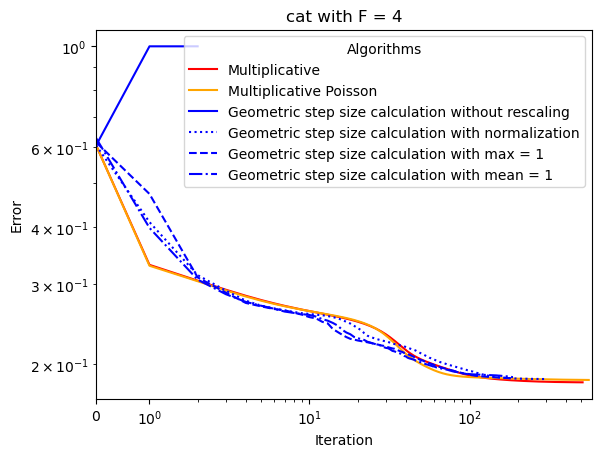

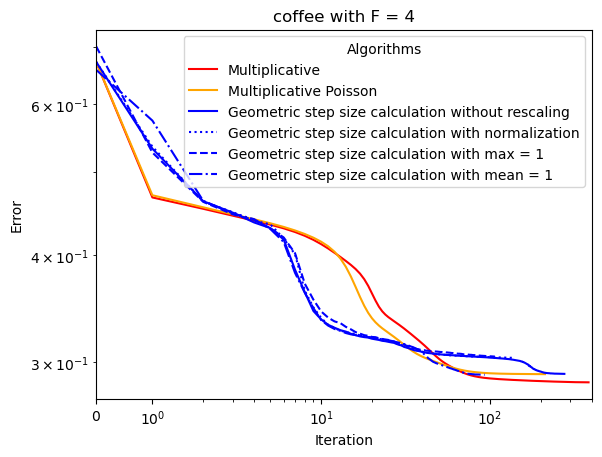

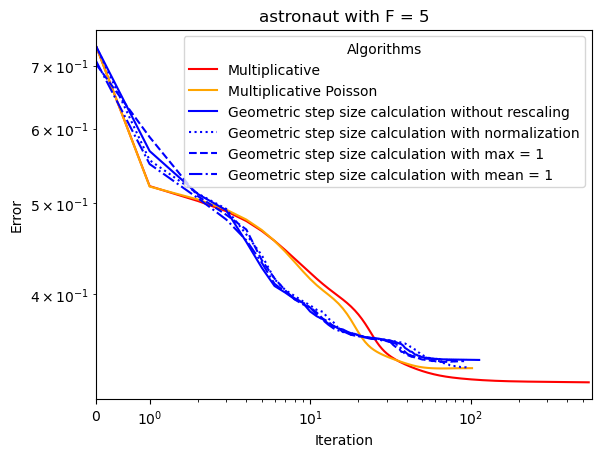

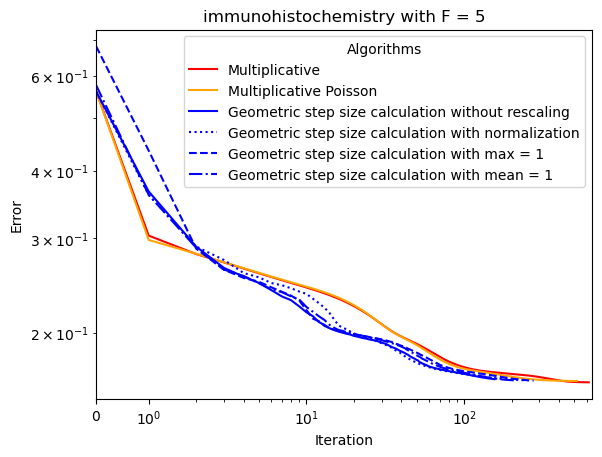

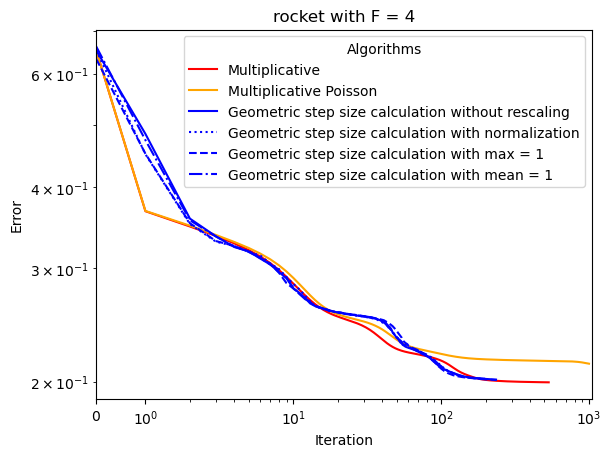

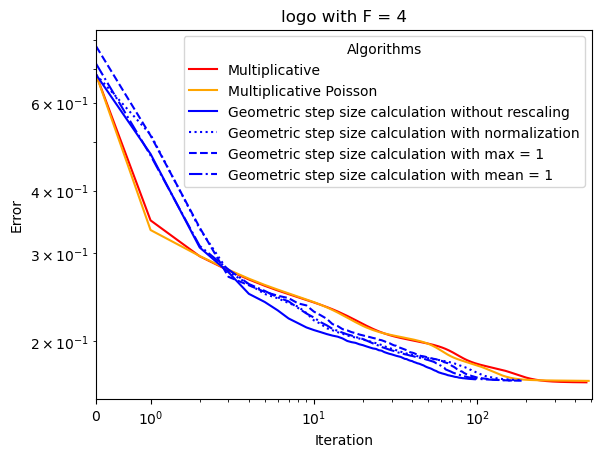

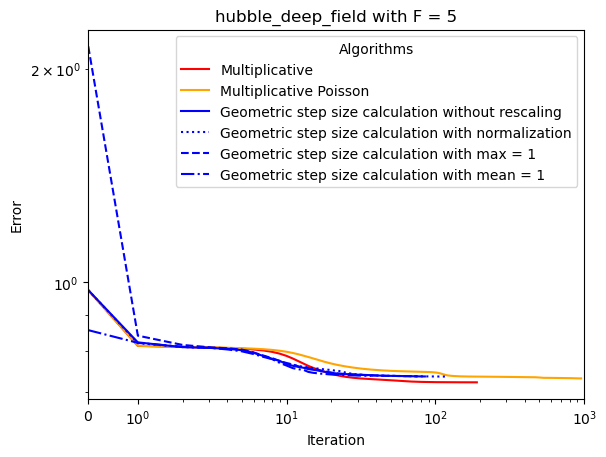

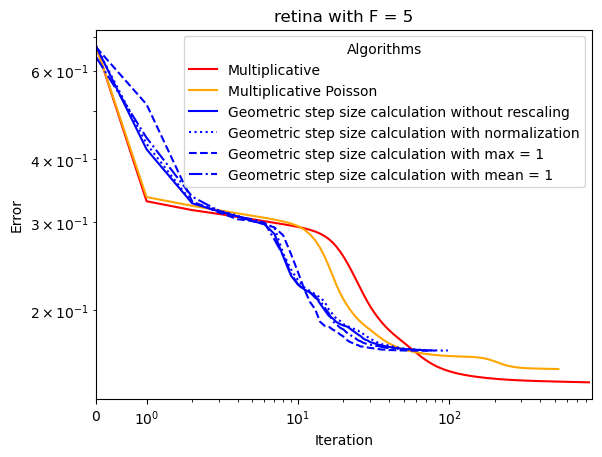

In [3]:
# CREATE FACTORIZER OBJECTS FOR ALL ALGORITHMS
max_iter = 1000

# The standart multiplicative algorithm
def multiplicative_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative = Factorizer("Multiplicative", multiplicative_factorization, color='red')

# The Poisson variant of the multiplicative algorithm
def multiplicative_poisson_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative_poisson = Factorizer("Multiplicative Poisson", multiplicative_poisson_factorization, color='orange')


# The new geometric algorithm with step size calculation and without any form of normalization
def geometric_variable_step_size(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric = Factorizer("Geometric step size calculation without rescaling", geometric_variable_step_size, color='blue')

# The new geometric algorithm with step size calculation and but normalization of the tensor and the initial data
def geometric_variable_normalized(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    norm_of_tensor = tl.norm(tensor)
    tensor_copy = tensor / norm_of_tensor # normalize tensor
    norm_of_approximation = tl.norm(defactorizing_CP(initial_A_ns, tensor.shape))
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / norm_of_approximation) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_norm = Factorizer("Geometric step size calculation with normalization", geometric_variable_normalized, color='blue', linestyle='dotted')

# The new geometric algorithm with step size calculation and but max=1 of the tensor and the initial data
def geometric_variable_normalize_max(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.max(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.max(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_max = Factorizer("Geometric step size calculation with max = 1", geometric_variable_normalize_max, color='blue', linestyle='dashed')

# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_variable_normalize_mean(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.mean(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='dashdot')



# TODO
def geometric_fixed_step_size(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_fixed = Factorizer("Geometric step size calculation", geometric_variable_step_size, color='blue')


# run the factorization on gpu
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
#context = {}
factorizers = [
    factorizer_multiplicative,
    factorizer_multiplicative_poisson,
    factorizer_geometric,
    factorizer_geometric_norm,
    factorizer_geometric_max,
    factorizer_geometric_mean,
]
evaluate_algorithms(factorizers, context=context)